<a href="https://colab.research.google.com/github/mthsansu/MLNLP/blob/side/Code/Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><center><strong><font color="chillipepper">Parlementarian Sentiment Analysis: Sequence Classification</font></strong></center></h1>
<h3><center><font color="green"><strong>Baseline Model</strong></font></center></h3>

<center>
April 2022, Houri & Sansu
</center>

## <font color="chillipepper">Modules and packages</font>

In [1]:
!pip install datasets

     |████████████████████████████████| 325 kB 17.2 MB/s 
     |████████████████████████████████| 212 kB 61.2 MB/s 
     |████████████████████████████████| 1.1 MB 64.4 MB/s 
     |████████████████████████████████| 77 kB 8.4 MB/s 
     |████████████████████████████████| 136 kB 73.3 MB/s 
     |████████████████████████████████| 127 kB 70.3 MB/s 
     |████████████████████████████████| 144 kB 69.5 MB/s 
     |████████████████████████████████| 271 kB 70.8 MB/s 
     |████████████████████████████████| 94 kB 3.8 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [2]:
import torch
import numpy as np
import datasets
from datasets import load_dataset
from tqdm import tqdm
import nltk
from nltk.tokenize import TreebankWordTokenizer, TweetTokenizer
import pandas as pd
from collections import Counter
import torchtext
from sklearn.model_selection import train_test_split
from termcolor import colored
import torch
import torch.nn as nn
import torch.nn.functional as F
import re

### <font color="chillipepper">**Preprocessing function**</font>

In [3]:
def clean(text): # Parameter will be a text, here a tweet
    text = re.sub("@","", text) # Removing the "@" from mention
    text = re.sub(r'http\S+', '', text) # Removing url links
    text = text.replace('\n',' ') # Removing new line
    text = text.replace('\r',' ') # Removing new line
    text = re.sub('#', '', text) # Removing hash
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text) # remove emoji
    a = re.compile('<U(.*?)>') # other missing emoji_pattern
    text = a.sub(r'', text) # remove these remaining emoji
    text = re.sub(' +', ' ', text) # Remove additional spaces
    return text # The output is the cleaned text

## <font color="chillipepper">Data</font>

**Import the annotated data**

In [4]:
# Import data
git_url = "https://raw.githubusercontent.com/mthsansu/MLNLP/main/Data/"
df = pd.read_csv(git_url + 'df_baseline.csv', index_col =0)

In [5]:
df["text"] = df["text"].apply(lambda x: clean(x))

In [6]:
df = df.rename(columns={'Label': 'label'})

**Prepare the data for machine learning tasks**

In [7]:
# Randomly split the data into train, test and validation sets using numpy
train, validate, test = \
              np.split(df.sample(frac=1, random_state=42), 
                       [int(.6*len(df)), int(.8*len(df))])

In [8]:
import pyarrow as pa
import pyarrow.dataset as ds
from datasets import Dataset

### convert to Huggingface dataset
train_dataset = Dataset(pa.Table.from_pandas(train))
test_dataset = Dataset(pa.Table.from_pandas(test))
val_dataset = Dataset(pa.Table.from_pandas(validate))

## <font color="chillipepper">Pre-trained Embeddings</font>

**First NLP tasks**

In [9]:
# Run only once: several min long
# Import fasttext vectors through torch text (it will download it only once)
from torchtext.vocab import vocab, FastText

pretrained_vectors = FastText(language='fr')

.vector_cache/wiki.fr.vec: 3.03GB [02:23, 21.1MB/s]                            
100%|██████████| 1152449/1152449 [01:52<00:00, 10277.32it/s]


In [10]:
pretrained_vocab = vocab(pretrained_vectors.stoi)
unk_token = "<unk>"
unk_index = 0
pad_token = '<pad>'
pad_index = 1
pretrained_vocab.insert_token("<unk>",unk_index)
pretrained_vocab.insert_token("<pad>", pad_index)
#this is necessary otherwise it will throw runtime error if OOV token is queried 
pretrained_vocab.set_default_index(unk_index)
pretrained_embeddings = pretrained_vectors.vectors
pretrained_embeddings = torch.cat((torch.zeros(1,pretrained_embeddings.shape[1]),pretrained_embeddings))
pretrained_embeddings.size()

torch.Size([1152450, 300])

## <font color="chillipepper">Tokenization</font>

In [11]:
# Import nltk's TweetTokenizer to use it in the definition of our own tokenizer functions
from nltk.tokenize import TweetTokenizer
from tqdm.notebook import tqdm

tok = TweetTokenizer()

In [12]:
# This function will tokenize each tweet, standardize the string sizes using zero-padding, and numericalize each token to an index
def tokenize_pad_numericalize(entry, vocab_stoi, max_length=20):
  text = [ vocab_stoi[token] if token in vocab_stoi else vocab_stoi['<unk>'] for token in tok.tokenize(entry.lower())]
  padded_text = None
  if len(text) < max_length:   padded_text = text + [ vocab_stoi['<pad>'] for i in range(len(text), max_length) ] 
  elif len(text) > max_length: padded_text = text[:max_length]
  else:                        padded_text = text
  return padded_text

# This function is a generalization of the function above, now applicable to multiple tweets at a time
def tokenize_all(entries, vocab_stoi):
  res = {}
  res['text'] = [tokenize_pad_numericalize(entry, vocab_stoi, max_length=200) for entry in entries['text']]
  return res

In [13]:
# Tokenize our three data subsets
train_dataset = train_dataset.map(lambda e: tokenize_all(e, pretrained_vocab.get_stoi()), batched=True)
test_dataset = test_dataset.map(lambda e: tokenize_all(e, pretrained_vocab.get_stoi()), batched=True)
val_dataset = val_dataset.map(lambda e: tokenize_all(e, pretrained_vocab.get_stoi()), batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

## <font color="chillipepper">Building of the model</font>

In [14]:
# Create the Dataset class

from torch.utils.data import Dataset

class TweetDataset(Dataset):
    def __init__(self, data, args):
      # args is a dict, a nice way to share the global arguments (even accross multiple files)
      self.args = args
      self.data = data

    def __len__(self):
      return len(self.data)
    
    def __getitem__(self, idx):
      item = {
          "text": np.array(self.data[idx]['text']),
          "label": np.array(self.data[idx]['label'])
      }
      return item

In [15]:
# Create DataLoader
from torch.utils.data import DataLoader
args = {'bsize': 64}
train_loader = DataLoader(TweetDataset(train_dataset, args), batch_size=args['bsize'], num_workers=2, shuffle=True, drop_last=True)
test_loader  = DataLoader(TweetDataset(test_dataset, args), batch_size=args['bsize'], num_workers=2, shuffle=True, drop_last=True)
val_loader  = DataLoader(TweetDataset(val_dataset, args), batch_size=args['bsize'], num_workers=2, shuffle=True, drop_last=True)

In [16]:
# Define the model to classify tweets

class TweetModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, pretrained_vectors=None):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.
        """
        super(TweetModel, self).__init__()
        # apply the pretrained embeddings to transform our token indices, into vectors
        self.ebd = torch.nn.Embedding.from_pretrained(pretrained_vectors, freeze=True)
        self.hidden_linear_layer = torch.nn.Linear(hidden_dim, hidden_dim, bias=True)
        self.classification_layer = torch.nn.Linear(hidden_dim, output_dim, bias=True)
        # softmax layer to compute class probabilities
        # https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html?highlight=softmax#torch.nn.Softmax
        self.softmax = nn.Softmax(dim=1)

        # define the dropout strategy (here, 20% (0.2) of the vector is ignored to prevent overfitting)
        # we don't use it here but it's a good thing to keep in mind
        # self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        # apply the pretrained embeddings
        x  = self.ebd(x)
        x  = x.mean(1)
        h  = torch.relu(self.hidden_linear_layer( x ))
        # h  = self.dropout(h)
        h  = self.classification_layer(h)
        logits = self.softmax(h)
        return logits

In [17]:
sizes = next(iter(train_loader))['text'].size()
batchsize = sizes[0] # We have chosen a batchsize equal to 64
inputdim  = sizes[1] # The input layer of our NN has 200 elements because when we padded the data, we set max_length=200
print(batchsize, inputdim)

64 200


In [18]:
hiddendim = 300 # dimension of the pretrained vector
outputdim = 3 # because there is 3 classes, i.e. 3 labels
# we instanciate the model
tweet_model = TweetModel(inputdim, hiddendim, outputdim, pretrained_vectors=pretrained_vectors.vectors)

In [19]:
# we can look at the model 
tweet_model

TweetModel(
  (ebd): Embedding(1152449, 300)
  (hidden_linear_layer): Linear(in_features=300, out_features=300, bias=True)
  (classification_layer): Linear(in_features=300, out_features=3, bias=True)
  (softmax): Softmax(dim=1)
)

**We'll need a GPU**

In [20]:
if torch.cuda.is_available():
  device = 'cuda'
  print('DEVICE = ', colored(torch.cuda.get_device_name(0), "green" ) )
else:
  device = 'cpu'
  print('DEVICE = ', colored('CPU', "blue"))
tweet_model.to(device)

DEVICE =  Tesla T4


TweetModel(
  (ebd): Embedding(1152449, 300)
  (hidden_linear_layer): Linear(in_features=300, out_features=300, bias=True)
  (classification_layer): Linear(in_features=300, out_features=3, bias=True)
  (softmax): Softmax(dim=1)
)

**Train the model**

In [21]:
# Training loop

def train(model, optimizer, ep, args):
  # set the model into a training mode : the model's weights and parameters WILL BE updated!
  model.train()
  # initialize empty lists for losses and accuracies
  loss_it, acc_it = list(), list()

  # start the loop over all the training batches. This means one full epoch.
  for it, batch in tqdm(enumerate(train_loader), desc="Epoch %s:" % (ep), total=train_loader.__len__()):
    
    batch = {'text': batch['text'].to(device), 'label': batch['label'].to(device)}

    # put parameters of the model and the optimizer to zero before doing another iteration. this prevents the gradient accumulation through batches
    optimizer.zero_grad()

    # apply the model on the batch
    logits = model(batch['text'])

    # # # to deal with unbalanced data in the batch, we calculate the weights according to their inverse frequency
    b_counter = Counter(batch['label'].detach().cpu().tolist())
    b_weights = torch.tensor( [ sum(batch['label'].detach().cpu().tolist()) / b_counter[label] if b_counter[label] > 0 else 0 for label in list(range(args['num_class'])) ] )
    b_weights = b_weights.to(device)

    # we choose the CrossEntropyLoss, suitable for multiclass classification
    # https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss
    loss_function = nn.CrossEntropyLoss(weight=b_weights)
    # loss_function = nn.CrossEntropyLoss()
    loss = loss_function(logits, batch['label'])

    # compute backpropagation
    loss.backward()

    # indicate to the optimizer we've done a step
    optimizer.step()

    # append the value of the loss for the current iteration (it). .item() retrieve the nuclear value as a int/long
    loss_it.append(loss.item())

    # get the predicted tags using the maximum probability from the softmax
    _, tag_seq  = torch.max(logits, 1)
    
    # Those 3 lines compute the accuracy and then append it the same way as the loss above
    correct = (tag_seq.flatten() == batch['label'].flatten()).float().sum()
    acc = correct / batch['label'].flatten().size(0)
    acc_it.append(acc.item())

  # simple averages of losses and accuracies for this epoch
  loss_it_avg = sum(loss_it)/len(loss_it)
  acc_it_avg = sum(acc_it)/len(acc_it)
  
  # print useful information about the training progress and scores on this training set's full pass (i.e. 1 epoch)
  print("Epoch %s/%s : %s : (%s %s) (%s %s)" % (colored(str(ep), 'blue'),args['max_eps'] , colored('Training', 'blue'), colored('loss', 'cyan'), sum(loss_it)/len(loss_it), colored('acc', 'cyan'), sum(acc_it) / len(acc_it)))


In [22]:
def inference(target, loader, model):
  """
    Args:
      target (str): modify the display, usually either 'validation' or 'test'
  """

  # set the model into a evaluation mode : the model's weights and parameters will NOT be updated!
  model.eval()

  # intialize empty list to populate later on
  loss_it, acc_it, f1_it = list(), list(), list()
  # preds = predicted values ; trues = true values .... obviously~
  preds, trues = list(), list()

  # loop over the loader batches
  for it, batch in tqdm(enumerate(loader), desc="%s:" % (target), total=loader.__len__()):
    # set an environnement without any gradient. So the tensor gradients are not considered 
    # (saves a lot of computation and memory, this is one of the many things that makes predicting far less costly than training)
    with torch.no_grad():

      # put the batch to the correct device
      batch = {'text': batch['text'].to(device), 'label': batch['label'].to(device)}

      # apply the model
      logits = model(batch['text'])

      # # to deal with unbalanced data in the batch, we calculate the weights according to their inverse frequency
      # b_counter = Counter(batch['label'].detach().cpu().tolist())
      # b_weights = torch.tensor( [ sum(batch['label'].detach().cpu().tolist()) / b_counter[label] if b_counter[label] > 0 else 0 for label in list(range(20)) ] )
      # b_weights = b_weights.to(device)

      # loss_function = nn.CrossEntropyLoss(weight=b_weights)
      loss_function = nn.CrossEntropyLoss()
      loss = loss_function(logits, batch['label'])

      # no need to backward() and other training stuff. Directly store the loss in the list
      loss_it.append(loss.item())

      # get the predicted tags using the maximum probability from the softmax
      _, tag_seq  = torch.max(logits, 1)
      
      # compute the accuracy and store it
      correct = (tag_seq.flatten() == batch['label'].flatten()).float().sum()
      acc = correct / batch['label'].flatten().size(0)
      acc_it.append(acc.item())
      
      # extend the predictions and true labels lists so we can compare them later on
      # note how we first ensure the tensor are on cpu (.cpu()), then we detach() the gradient from the tensor, before transforming it to a simple python list (.tolist())
      preds.extend(tag_seq.cpu().detach().tolist())
      trues.extend(batch['label'].cpu().detach().tolist())

  # compute the average loss and accuracy accross the iterations (batches)
  loss_it_avg = sum(loss_it)/len(loss_it)
  acc_it_avg = sum(acc_it)/len(acc_it)
  
  # print useful information. Important during training as we want to know the performance over the validation set after each epoch
  print("%s : (%s %s) (%s %s)" % ( colored(target, 'blue'), colored('loss', 'cyan'), sum(loss_it)/len(loss_it), colored('acc', 'cyan'), sum(acc_it) / len(acc_it)))

  # return the true and predicted values with the losses and accuracies
  return trues, preds, loss_it_avg, acc_it_avg, loss_it, acc_it

In [89]:
# Start training

import torch.optim as optim

def run_epochs(model, args):

  # args['device'] =device
  if args['cuda'] != -1:
      model.cuda(args['cuda'])
      device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
      args['device'] = device
      print("device set to %s" % (device) )

  # we set the optimizer as Adam with the learning rate (lr) set in the arguments
  # you can look at the different optimizer available here: https://pytorch.org/docs/stable/optim.html
  optimizer = optim.Adam(model.parameters(), lr = args['lr'])
  # optimizer = optim.Adagrad(model.parameters(), lr=args['lr'])

  # define an empty list to store validation losses for each epoch
  val_ep_losses = list()
  # iterate over the number of max epochs set in the arguments
  for ep in range(args['max_eps']):
    # train the model using our defined function
    train(model, optimizer, ep, args)
    # apply the model for inference using our defined function
    trues, preds, val_loss_it_avg, val_acc_it_avg, val_loss_it, val_acc_it = inference("validation", val_loader, model)
    # append the validation losses (good losses should normally go down)
    val_ep_losses.append(val_loss_it_avg)

  # return the list of epoch validation losses in order to use it later to create a plot
  return val_ep_losses
    

In [90]:
def predict(target, loader, model):
  """
    Args:
      target (str): modify the display, usually either 'validation' or 'test'
  """

  # set the model into a evaluation mode : the model's weights and parameters will NOT be updated!
  model.eval()

  # intialize empty list to populate later on
  #loss_it, acc_it, f1_it = list(), list(), list()
  # preds = predicted values ; trues = true values .... obviously~
  #preds, trues = list(), list()
  ids, preds = list(), list()

  # loop over the loader batches
  for it, batch in tqdm(enumerate(loader), desc="%s:" % (target), total=loader.__len__()):
    # set an environnement without any gradient. So the tensor gradients are not considered 
    # (saves a lot of computation and memory, this is one of the many things that makes predicting far less costly than training)
    with torch.no_grad():

      # put the batch to the correct device
      batch = {'text': batch['text'].to(device), 'id': batch['id'].to(device)}
      #batch = {'text': batch['text'].to(device)}

      # apply the model
      logits = model(batch['text'])

      # # to deal with unbalanced data in the batch, we calculate the weights according to their inverse frequency
      # b_counter = Counter(batch['label'].detach().cpu().tolist())
      # b_weights = torch.tensor( [ sum(batch['label'].detach().cpu().tolist()) / b_counter[label] if b_counter[label] > 0 else 0 for label in list(range(20)) ] )
      # b_weights = b_weights.to(device)

      # loss_function = nn.CrossEntropyLoss(weight=b_weights)
      #loss_function = nn.CrossEntropyLoss()
      #loss = loss_function(logits, batch['label'])

      # no need to backward() and other training stuff. Directly store the loss in the list
      #loss_it.append(loss.item())

      # get the predicted tags using the maximum probability from the softmax
      _, tag_seq  = torch.max(logits, 1)
      
      # compute the accuracy and store it
      #correct = (tag_seq.flatten() == batch['label'].flatten()).float().sum()
      #acc = correct / batch['label'].flatten().size(0)
      #acc_it.append(acc.item())
      
      # extend the predictions and true labels lists so we can compare them later on
      # note how we first ensure the tensor are on cpu (.cpu()), then we detach() the gradient from the tensor, before transforming it to a simple python list (.tolist())
      preds.extend(tag_seq.cpu().detach().tolist())
      ids.extend(batch['id'].cpu().detach().tolist())

  # compute the average loss and accuracy accross the iterations (batches)
  #loss_it_avg = sum(loss_it)/len(loss_it)
  #acc_it_avg = sum(acc_it)/len(acc_it)
  
  # print useful information. Important during training as we want to know the performance over the validation set after each epoch
  #print("%s : (%s %s) (%s %s)" % ( colored(target, 'blue'), colored('loss', 'cyan'), sum(loss_it)/len(loss_it), colored('acc', 'cyan'), sum(acc_it) / len(acc_it)))

  # return the true and predicted values with the losses and accuracies
  #return trues, preds, loss_it_avg, acc_it_avg, loss_it, acc_it
  return ids, preds

In [91]:
# here you can specify if you want a GPU or a CPU by setting the cuda argument as -1 for CPU and another index for GPU. If you only have one GPU, put 0.
args.update({'max_eps': 50, 'lr': 0.001, 'device': 'gpu', 'cuda': 0, 'num_class': 3})
# 1e-05
print('device', device)
# Instantiate model with pre-trained glove vectors
# model = TweetModel(pretrained_embeddings, args['num_class'], args, dimension=50, freeze_embeddings = True )
tweet_model = TweetModel(inputdim, hiddendim, outputdim, pretrained_vectors=pretrained_vectors.vectors)
loss_list_val = run_epochs(tweet_model, args)

device cuda
device set to cuda


Epoch 0::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 0/50 : Training : (loss 1.0977449152204726) (acc 0.3663194444444444)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0952396790186565) (acc 0.4270833333333333)


Epoch 1::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 1/50 : Training : (loss 1.0951728820800781) (acc 0.4027777777777778)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0943191051483154) (acc 0.4114583333333333)


Epoch 2::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 2/50 : Training : (loss 1.0916487905714247) (acc 0.3993055555555556)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0860003232955933) (acc 0.4322916666666667)


Epoch 3::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 3/50 : Training : (loss 1.0867522822486029) (acc 0.3975694444444444)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0823390483856201) (acc 0.4322916666666667)


Epoch 4::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 4/50 : Training : (loss 1.0814001560211182) (acc 0.3940972222222222)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0862609148025513) (acc 0.4010416666666667)


Epoch 5::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 5/50 : Training : (loss 1.0761449337005615) (acc 0.3854166666666667)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0821709235509236) (acc 0.3958333333333333)


Epoch 6::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 6/50 : Training : (loss 1.0726971758736505) (acc 0.3958333333333333)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0822095076243083) (acc 0.390625)


Epoch 7::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 7/50 : Training : (loss 1.0677019092771742) (acc 0.4079861111111111)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0650627215703328) (acc 0.4375)


Epoch 8::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 8/50 : Training : (loss 1.0649270216623943) (acc 0.4045138888888889)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0639591217041016) (acc 0.4114583333333333)


Epoch 9::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 9/50 : Training : (loss 1.0635509623421564) (acc 0.4166666666666667)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0920436779658) (acc 0.3697916666666667)


Epoch 10::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 10/50 : Training : (loss 1.0633246368832059) (acc 0.40625)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0616529782613118) (acc 0.421875)


Epoch 11::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 11/50 : Training : (loss 1.0609226094351873) (acc 0.4288194444444444)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0648009777069092) (acc 0.4479166666666667)


Epoch 12::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 12/50 : Training : (loss 1.0554293261633978) (acc 0.4201388888888889)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0809624989827473) (acc 0.375)


Epoch 13::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 13/50 : Training : (loss 1.0553493234846327) (acc 0.40625)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0659900108973186) (acc 0.4427083333333333)


Epoch 14::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 14/50 : Training : (loss 1.051502572165595) (acc 0.3975694444444444)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0765567620595295) (acc 0.4010416666666667)


Epoch 15::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 15/50 : Training : (loss 1.053488638665941) (acc 0.4322916666666667)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0673598845799763) (acc 0.453125)


Epoch 16::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 16/50 : Training : (loss 1.0506220526165433) (acc 0.4236111111111111)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0579744577407837) (acc 0.4375)


Epoch 17::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 17/50 : Training : (loss 1.0520571602715387) (acc 0.4079861111111111)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0649830897649128) (acc 0.4322916666666667)


Epoch 18::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 18/50 : Training : (loss 1.0476176341374714) (acc 0.4444444444444444)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0657978057861328) (acc 0.421875)


Epoch 19::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 19/50 : Training : (loss 1.043408195177714) (acc 0.4184027777777778)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.080237587292989) (acc 0.3854166666666667)


Epoch 20::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 20/50 : Training : (loss 1.0459148155318365) (acc 0.4548611111111111)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0745445489883423) (acc 0.4114583333333333)


Epoch 21::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 21/50 : Training : (loss 1.043772366311815) (acc 0.4409722222222222)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.061790108680725) (acc 0.4114583333333333)


Epoch 22::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 22/50 : Training : (loss 1.0387432310316298) (acc 0.4322916666666667)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0578415393829346) (acc 0.4635416666666667)


Epoch 23::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 23/50 : Training : (loss 1.0409740606943767) (acc 0.4965277777777778)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0783580144246419) (acc 0.3802083333333333)


Epoch 24::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 24/50 : Training : (loss 1.0426799986097548) (acc 0.4513888888888889)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0690998633702595) (acc 0.4375)


Epoch 25::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 25/50 : Training : (loss 1.035112248526679) (acc 0.4791666666666667)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0688773393630981) (acc 0.4114583333333333)


Epoch 26::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 26/50 : Training : (loss 1.0341625544759963) (acc 0.4722222222222222)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0728171666463215) (acc 0.4375)


Epoch 27::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 27/50 : Training : (loss 1.0308403041627672) (acc 0.5)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0750152667363484) (acc 0.390625)


Epoch 28::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 28/50 : Training : (loss 1.0335485802756414) (acc 0.4739583333333333)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0618408521016438) (acc 0.4375)


Epoch 29::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 29/50 : Training : (loss 1.028582559691535) (acc 0.5)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.060835639635722) (acc 0.4166666666666667)


Epoch 30::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 30/50 : Training : (loss 1.0301019019550748) (acc 0.4947916666666667)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0702346563339233) (acc 0.4322916666666667)


Epoch 31::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 31/50 : Training : (loss 1.0269914865493774) (acc 0.5173611111111112)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0673637390136719) (acc 0.421875)


Epoch 32::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 32/50 : Training : (loss 1.0263531737857394) (acc 0.5277777777777778)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0574524402618408) (acc 0.4375)


Epoch 33::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 33/50 : Training : (loss 1.0189322498109605) (acc 0.5329861111111112)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.062720497449239) (acc 0.4583333333333333)


Epoch 34::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 34/50 : Training : (loss 1.023888521724277) (acc 0.5208333333333334)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0399196147918701) (acc 0.4791666666666667)


Epoch 35::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 35/50 : Training : (loss 1.0230185455746121) (acc 0.5138888888888888)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0556035439173381) (acc 0.40625)


Epoch 36::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 36/50 : Training : (loss 1.0232203867700365) (acc 0.5399305555555556)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0819460153579712) (acc 0.40625)


Epoch 37::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 37/50 : Training : (loss 1.01534104347229) (acc 0.5451388888888888)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.068413774172465) (acc 0.4114583333333333)


Epoch 38::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 38/50 : Training : (loss 1.0200307501686945) (acc 0.53125)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0496431589126587) (acc 0.453125)


Epoch 39::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 39/50 : Training : (loss 1.0132698284255133) (acc 0.5069444444444444)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0822575489679973) (acc 0.4010416666666667)


Epoch 40::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 40/50 : Training : (loss 1.010453701019287) (acc 0.5381944444444444)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0581881602605183) (acc 0.4166666666666667)


Epoch 41::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 41/50 : Training : (loss 1.0118330518404643) (acc 0.5295138888888888)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0642905632654827) (acc 0.4010416666666667)


Epoch 42::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 42/50 : Training : (loss 1.0057467354668512) (acc 0.5399305555555556)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0602790514628093) (acc 0.484375)


Epoch 43::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 43/50 : Training : (loss 1.00597169664171) (acc 0.5434027777777778)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0575995047887166) (acc 0.4739583333333333)


Epoch 44::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 44/50 : Training : (loss 1.0033932394451566) (acc 0.5885416666666666)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0508925517400105) (acc 0.453125)


Epoch 45::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 45/50 : Training : (loss 0.9981463617748685) (acc 0.5677083333333334)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.075883388519287) (acc 0.4166666666666667)


Epoch 46::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 46/50 : Training : (loss 0.998461021317376) (acc 0.5729166666666666)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.06231423219045) (acc 0.4427083333333333)


Epoch 47::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 47/50 : Training : (loss 0.9949203332265218) (acc 0.5659722222222222)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0552568038304646) (acc 0.4322916666666667)


Epoch 48::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 48/50 : Training : (loss 0.9960898955663046) (acc 0.5833333333333334)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0721841255823772) (acc 0.4166666666666667)


Epoch 49::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 49/50 : Training : (loss 0.9911032517751058) (acc 0.5798611111111112)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0636449654897053) (acc 0.40625)


Let's plot the loss function

In [92]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_loss(loss_list):
  '''
  this function creates a plot. a simple curve showing the different values at each steps.
  Here we use it to plot the loss so we named it plot_loss, but the same function with different titles could be used to plot accuracies
  or other metrics for instance.
  
  Args:
    loss_list (list of floats): list of numerical values
  '''
  plt.plot(range(len(loss_list)), loss_list)
  plt.xlabel('epochs')
  # in our model we use Softmax then NLLLoss which means Cross Entropy loss
  plt.ylabel('Cross Entropy')
  # in our training loop we used an Adam optimizer so we indicate it there
  plt.title('lr: {}, optim_alg:{}'.format(args['lr'], 'Adam'))

  # let's directly show the plot when calling this function
  plt.show()

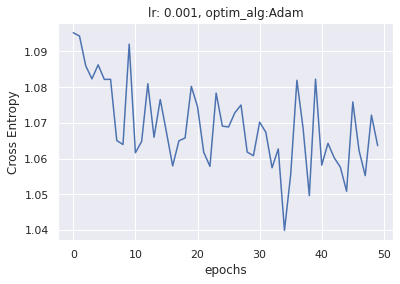

In [93]:
# let's call our function using the list of validation losses to show the plot
plot_loss(loss_list_val)

**Evaluate the model**

Evaluate model performance on the train set

In [94]:
# let's use our model for inference on the test set. We can short it by naming it "test our model"
# we set the target as "test" to print the correct info, and use the test loader
trues, preds, loss_it_avg, acc_it_avg, loss_it, acc_it = inference("test", test_loader, tweet_model)

test::   0%|          | 0/3 [00:00<?, ?it/s]

test : (loss 1.0172948837280273) (acc 0.5104166666666666)


In [95]:
# let's look at the first ten predictions
for t, p in zip(trues[:10], preds[:10]):
  correct = colored('Correct', 'green') if t == p else colored('Mistake', 'red')
  print('true', t, 'predicted', p, correct)

true 1 predicted 0 Mistake
true 2 predicted 0 Mistake
true 2 predicted 2 Correct
true 2 predicted 2 Correct
true 2 predicted 1 Mistake
true 0 predicted 0 Correct
true 1 predicted 0 Mistake
true 2 predicted 0 Mistake
true 1 predicted 0 Mistake
true 0 predicted 0 Correct


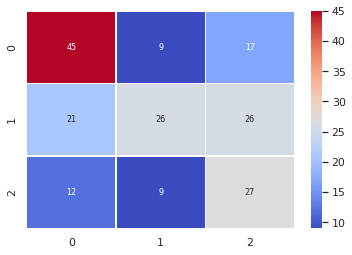

In [96]:
# Confusion matrix

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, plot_roc_curve
import matplotlib.pyplot as plt
import seaborn as sn
names = [0,1,2]
cm = confusion_matrix(np.array(trues).flatten(), np.array(preds).flatten())
df_cm = pd.DataFrame(cm, index=names, columns=names)
# config plot sizes
sn.set(font_scale=1)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 8}, cmap='coolwarm', linewidth=0.5, fmt="")
plt.show()

Evaluate model performance on the validation set

In [50]:
trues, preds, loss_it_avg, acc_it_avg, loss_it, acc_it = inference("validate", val_loader, tweet_model)

validate::   0%|          | 0/3 [00:00<?, ?it/s]

validate : (loss 1.0651903947194417) (acc 0.390625)


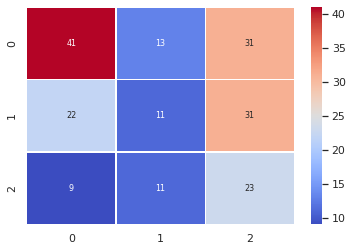

In [51]:
# Confusion matrix

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, plot_roc_curve
import matplotlib.pyplot as plt
import seaborn as sn
names = [0,1,2]
cm = confusion_matrix(np.array(trues).flatten(), np.array(preds).flatten())
df_cm = pd.DataFrame(cm, index=names, columns=names)
# config plot sizes
sn.set(font_scale=1)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 8}, cmap='coolwarm', linewidth=0.5, fmt="")
plt.show()

## Applying the model to the study dataset

In [52]:
# Import data
git_url = "https://raw.githubusercontent.com/mthsansu/MLNLP/main/Data/"
df = pd.read_csv(git_url + 'Tweets_sample_confinement.csv', index_col =0)

In [53]:
import pyarrow as pa
import pyarrow.dataset as ds
from datasets import Dataset

### convert to Huggingface dataset
df_conf = Dataset(pa.Table.from_pandas(df))

In [54]:
df_conf = df_conf.map(lambda e: tokenize_all(e, pretrained_vocab.get_stoi()), batched=True)

  0%|          | 0/33 [00:00<?, ?ba/s]

KeyboardInterrupt: ignored

In [ ]:
# Create the Dataset class

from torch.utils.data import Dataset

class TweetDatasetId(Dataset):
    def __init__(self, data, args):
      # args is a dict, a nice way to share the global arguments (even accross multiple files)
      self.args = args
      self.data = data

    def __len__(self):
      return len(self.data)
    
    def __getitem__(self, idx):
      item = {
          "text": np.array(self.data[idx]['text']),
          "id": np.array(self.data[idx]['id'])
      }
      return item

In [ ]:
# Create the data loader

# Create DataLoader
from torch.utils.data import DataLoader
args = {'bsize': 64}
df_conf_loader = DataLoader(TweetDatasetId(df_conf, args), batch_size=args['bsize'], num_workers=2, shuffle=True, drop_last=True)

In [ ]:
id_conf,pred_conf = predict("data_conf", df_conf_loader, tweet_model)

In [ ]:
df_pred = pd.DataFrame({"id": id_conf,"pred": pred_conf})

In [ ]:
df_pred

In [ ]:
df_pred.pred.value_counts()